In [82]:
## David Favela Corella
## CS4375.003


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import matplotlib.pyplot as plt

import PIL
import pathlib
import cv2

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

dataset_path = "/kaggle/input/pizza-not-pizza/pizza_not_pizza"

data_dir = pathlib.Path(dataset_path)

image_count = len(list(dataset_path))
print(image_count)

batch_size = 128
# num_classes = 10
# epochs = 20

# batch_size = 32
img_height = 180
img_width = 180
IMG_SHAPE = (img_height, img_width) + (3,)


45


Before going into the image classification models, it is worth mentioning the type of data I found. I used an image classification database that predicts which images contain a pizza in it. The database by itself contains 983 pizza and 983 non pizza pictures. In some of the algorithms, I used a mix of 50% pictures for training and 20% pictures for testing. The reason being that the models would take a long time to fit the data. I used the regular sequential model, the CNN model, the Xception model, and the transfer learning model. In the transfer learning model I included a version where it builds upon the original transfer learning model and improves it using fine tuning.

### Using Sequential model

Getting the train and validation datasets from origin.

In [83]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1966 files belonging to 2 classes.
Using 983 files for training.


In [84]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1966 files belonging to 2 classes.
Using 393 files for validation.


Printing out the names of the directories where the pictures are located. These are going to become the classes.

In [85]:
class_names = train_ds.class_names
print(class_names)

['not_pizza', 'pizza']


Shape of the data.

In [86]:
for data, labels in train_ds.take(1):
    print(data.shape)
    print(labels.shape)

(128, 180, 180, 3)
(128,)


Using matplotlib, we can see some images with their labels from the train dataset. It gives us an idea of the kind of images that are going to be processed.

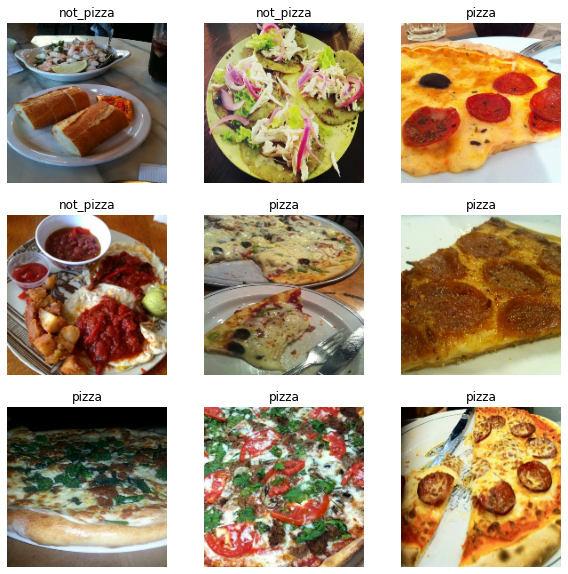

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Going into the train database, we can see the shape the images and labels have.

In [88]:
    
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 180, 180, 3)
(128,)


Creating the sequential image classification model.

In [89]:
num_classes = 2

model = Sequential([
  tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax'),
])


In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 97200)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               49766912  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 1026      
Total params: 50,030,594
Trainable params: 50,030,594
Non-trainable params: 0
__________________________________________

In [50]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy'])

epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


8/8 [==============================] - 4s 379ms/step - loss: 46798.3984 - accuracy: 0.5015 - val_loss: 2992.3518 - val_accuracy: 0.5064
Epoch 2/10
8/8 [==============================] - 3s 361ms/step - loss: 2138.2507 - accuracy: 0.5127 - val_loss: 1661.9385 - val_accuracy: 0.4936
Epoch 3/10
8/8 [==============================] - 3s 355ms/step - loss: 1276.6068 - accuracy: 0.5219 - val_loss: 927.6323 - val_accuracy: 0.4936
Epoch 4/10
8/8 [==============================] - 3s 362ms/step - loss: 597.3075 - accuracy: 0.5239 - val_loss: 27.4635 - val_accuracy: 0.6081
Epoch 5/10
8/8 [==============================] - 3s 359ms/step - loss: 80.1207 - accuracy: 0.5219 - val_loss: 1.0279 - val_accuracy: 0.5089
Epoch 6/10
8/8 [==============================] - 4s 378ms/step - loss: 103.5963 - accuracy: 0.5148 - val_loss: 0.8769 - val_accuracy: 0.5064
Epoch 7/10
8/8 [==============================] - 4s 384ms/step - loss: 0.7317 - accuracy: 0.5015 - val_loss: 0.6886 - val_accuracy: 0.5089
Epoch 8

Plotting the accuracy values as the epoch increases, we can see a small trend in the accuracy increasing as the epoch increases.

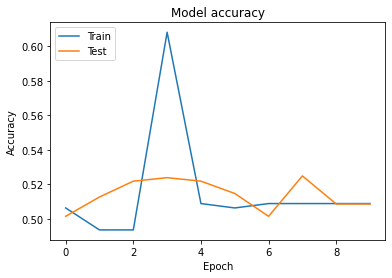

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
score = model.evaluate(val_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6887453198432922
Test accuracy: 0.508905827999115


The test accuracy for the regular sequential model was 0.50 on the validation data, which is quite low.

### Using CNN modeling

The CNN modeling algorithm allows for a reduction in the dimensionality of the database without it losing its information. From this, we can think that they might produce better results that the sequential model.
We also are going to set up the variables we're going to use for the model next.

In [144]:
batch_size = 128
num_classes = 2
epochs = 10

In [145]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [146]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [148]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Similar to the sequential model, we do need to make it sequential but we involve the use of Conv2D and MaxPooling2D, which help deal with high dimensionality.

In [149]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [150]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

We're going to compile the model using sparse categorical crossentropy for our loss function and and also are going to fit the model to the train database.

In [151]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds)


Epoch 1/10
8/8 [==============================] - 9s 991ms/step - loss: 1.1965 - accuracy: 0.4883 - val_loss: 0.7005 - val_accuracy: 0.5064
Epoch 2/10
8/8 [==============================] - 7s 912ms/step - loss: 0.6947 - accuracy: 0.5331 - val_loss: 0.6920 - val_accuracy: 0.5140
Epoch 3/10
8/8 [==============================] - 8s 970ms/step - loss: 0.6868 - accuracy: 0.5738 - val_loss: 0.6712 - val_accuracy: 0.5598
Epoch 4/10
8/8 [==============================] - 7s 929ms/step - loss: 0.6532 - accuracy: 0.6267 - val_loss: 0.6690 - val_accuracy: 0.5623
Epoch 5/10
8/8 [==============================] - 7s 915ms/step - loss: 0.5986 - accuracy: 0.6928 - val_loss: 0.6017 - val_accuracy: 0.7150
Epoch 6/10
8/8 [==============================] - 7s 926ms/step - loss: 0.5128 - accuracy: 0.7670 - val_loss: 0.5630 - val_accuracy: 0.6997
Epoch 7/10
8/8 [==============================] - 8s 976ms/step - loss: 0.4641 - accuracy: 0.7915 - val_loss: 0.5603 - val_accuracy: 0.7354
Epoch 8/10
8/8 [====

We again are going to plot the results into a matplot graph.

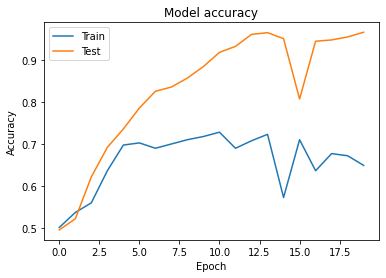

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As we can see, as the epoch increased, we got better accuracy on our test results, which is a good indicator for the model.

In [152]:
score = model.evaluate(val_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.724279522895813
Test accuracy: 0.6921119689941406


Overall test accuracy on the validation data was of 0.69, much improved from the regular sequential model for image classification, yet still a little bit unreliable.

### Using Xception image classification

The Xception model for image classification is a CNN one. While the CNN model produced earlier was a couple layers deep, Xception is 71 layers deep, making it really robust and accurate. It also can let you load the pretrained version which has been trained by over a million images. Here we're going to train it ourselves.

In [134]:
base_model = tf.keras.applications.Xception(
    input_shape=(180,180,3),
    include_top=False)  


We created the base model with the input shape of the images being (180,180), the same we set for other models.

In [157]:
base_model.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAvgPool2D(),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name="Xception")

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


We create the Xception model and then compile it.

In [158]:
model.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 21,386,281
Trainable params: 524,801
Non-trainable params: 20,861,480
_________________________________________________________________


In [159]:
# model.evaluate(train_ds)
history = model.fit(train_ds,
          epochs = 10,
          verbose=1,
          validation_data=val_ds)

Epoch 1/10
8/8 [==============================] - 55s 7s/step - loss: 0.0000e+00 - accuracy: 0.5300 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 2/10
8/8 [==============================] - 52s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 3/10
8/8 [==============================] - 52s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 4/10
8/8 [==============================] - 52s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 5/10
8/8 [==============================] - 52s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 6/10
8/8 [==============================] - 51s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 - val_accuracy: 0.5064
Epoch 7/10
8/8 [==============================] - 52s 7s/step - loss: 0.0000e+00 - accuracy: 0.5066 - val_loss: 0.0000e+00 -

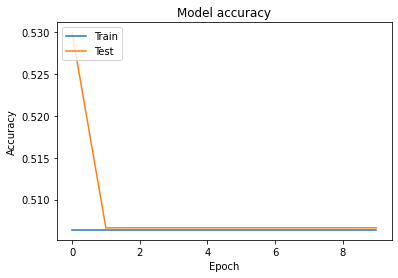

In [160]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [161]:
score = model.evaluate(val_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0
Test accuracy: 0.5063613057136536


We get the same results as the sequential model, which is not what was expected.

### Using Transfer Learning model

Transfer learning focuses on using a pretrained model to use on your own model. I will be doing customization on a pretrained model using feature extraction, where we extract the meaningful features learned by a previous network frmo new samples.

In [162]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [163]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


In [164]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data augmentation provides a good way of diversifying the dataset by applying realistic transformations to the train images. Here we are going to apply it as the dataset is not that large.

In [165]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

We can see in the next plot how data augmentation works on a sample image.

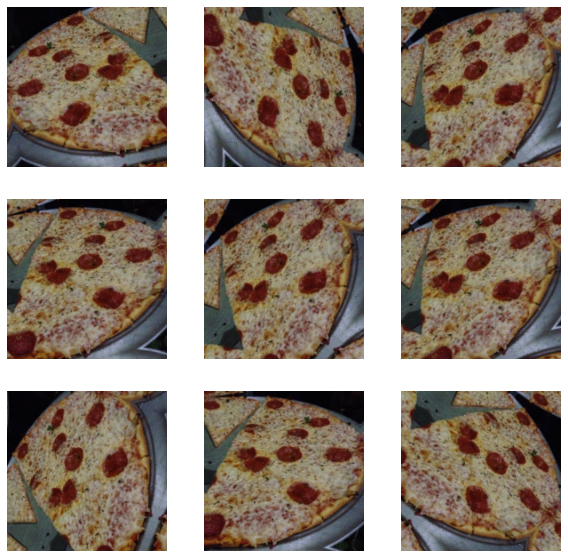

In [166]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

We rescale the pixel values.

In [167]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [168]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


Here is where we create the base model from the pretrained model. We are going to be using MobileNetV2, a model developed by Google, which has a large dataset of 1.4 million images and 1000 classes.

In [169]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (180, 180) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               alpha=1.0,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [171]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 6, 6, 1280)


Here is where feature extraction happens. Making the base model not trainable will freeze all of the base model's layers.

In [172]:
base_model.trainable = False


In [173]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_36[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [174]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [175]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


We create the model based on the base model and the feature extraction.

In [176]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

We compile the model with a base learning rate of 0.0001.

In [178]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [179]:
model.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0  

In [180]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 3s 463ms/step - loss: 0.8276 - accuracy: 0.4198


Fitting the model to the dataset.

In [181]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 0.8825 - accuracy: 0.4557 - val_loss: 0.7788 - val_accuracy: 0.4758
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 0.8206 - accuracy: 0.4975 - val_loss: 0.7336 - val_accuracy: 0.4987
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.7573 - accuracy: 0.5117 - val_loss: 0.6914 - val_accuracy: 0.5394
Epoch 4/10
8/8 [==============================] - 8s 1s/step - loss: 0.7372 - accuracy: 0.5402 - val_loss: 0.6524 - val_accuracy: 0.5700
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.6971 - accuracy: 0.5849 - val_loss: 0.6167 - val_accuracy: 0.6031
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.6459 - accuracy: 0.6094 - val_loss: 0.5844 - val_accuracy: 0.6361
Epoch 7/10
8/8 [==============================] - 8s 1s/step - loss: 0.6157 - accuracy: 0.6592 - val_loss: 0.5546 - val_accuracy: 0.6616
Epoch 8/10
8/8 [========================

Plotting the result of the transfer learning model, we get the following graph.

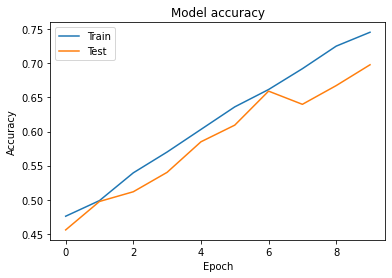

In [182]:
# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We see the clearest trendline in the transfer learning model, as both the train and test accuracy increase with an increase in epoch.

In [183]:
score = model.evaluate(validation_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.47770369052886963
Test accuracy: 0.7455470561981201


Overall, transfer learning gave a total accuracy of 0.74, similar to that of the CNN model. We'll try and see if by fine tuning the model we can get better results.

### Transfer Learning fine tuned

Now we make the base model not be frozen, so its layers can interact with the dataset.

In [184]:
base_model.trainable = True
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_36[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [185]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [186]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

We create the model again with the base model being trainable.

In [187]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [188]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [189]:
model.summary()


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_10  (None, 1280)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1280)              0  

In [190]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 3s 481ms/step - loss: 0.6652 - accuracy: 0.5573


In [191]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset)

Epoch 10/20
8/8 [==============================] - 36s 3s/step - loss: 0.4980 - accuracy: 0.7497 - val_loss: 0.3193 - val_accuracy: 0.8855
Epoch 11/20
8/8 [==============================] - 26s 3s/step - loss: 0.2942 - accuracy: 0.8850 - val_loss: 0.2518 - val_accuracy: 0.9033
Epoch 12/20
8/8 [==============================] - 26s 3s/step - loss: 0.2573 - accuracy: 0.8911 - val_loss: 0.2288 - val_accuracy: 0.9109
Epoch 13/20
8/8 [==============================] - 25s 3s/step - loss: 0.2276 - accuracy: 0.9105 - val_loss: 0.2042 - val_accuracy: 0.9211
Epoch 14/20
8/8 [==============================] - 26s 3s/step - loss: 0.2025 - accuracy: 0.9196 - val_loss: 0.1954 - val_accuracy: 0.9211
Epoch 15/20
8/8 [==============================] - 26s 3s/step - loss: 0.1757 - accuracy: 0.9308 - val_loss: 0.1833 - val_accuracy: 0.9186
Epoch 16/20
8/8 [==============================] - 26s 3s/step - loss: 0.1737 - accuracy: 0.9288 - val_loss: 0.1827 - val_accuracy: 0.9186
Epoch 17/20
8/8 [==========

Rendering the plot, we see that we got better results this time around.

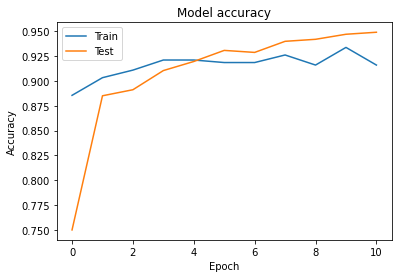

In [192]:
# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [193]:
score = model.evaluate(validation_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21557176113128662
Test accuracy: 0.9160305261611938


The test accuracy was 0.91, the best out of the models I tested.

### Analysis

Looking back to the approaches I took into modeling and testing the data, we can see that there was a clear divide on how the models worked with the train dataset and how that impactes its test accuracy. The lowest algorithms were the sequential and the Xception models. I believe the sequential model was at a low 0.50 due to how rudementary and simple it is. We do not work with high dimensionality like we do with CNN and we do not take into account a previous model to base it off on. The Xception model also had an accuracy of 0.50, which was really surprising as it is based off a CNN model of 71 layers. I believe that the accuracy was low due to how I handled the data. The CNN and transfer learning models were on par, both scoring around 0.70-0.75 on accuracy. The transfer learning model is a CNN one and we made it so the base model was not trainable, making it basically a CNN model, which is why I believe it got similar results to it. The fine tuned transfer algorithm did take into account the base model and made it trainablem which is why I believe it handled the train data better and thus gave a high accuracy of 0.91.

Overall, it was hard to work with these algorithms, as some of them had issues with the shape of the images. That's asloa big reason why I coulnd't work with RNN models, even though I tried. I do take away the functionality that the transfer learning models bring and how easily they can be applied to any dataset.